# Graph Wildfire Evacuation Experiment Results

This notebook is used to collate data from experiments and create the figures used in the forthcoming manuscript, "Evaluating Implications of Problematic Routing Assumptions in Spatially Explicit Agent-Based Models of Wildfire Evacuation" by Rebecca Vandewalle, Jeon-Young Kang, and Shaowen Wang.

See the [FireABM_Demo_Notebook](./FireABM_Demo_Notebook.ipynb) for more information on the code needed to create the simulation results that are used in this notebook.

<a id='top'></a>
## Table of Contents
- [Initial setup](#setup)
- [Initial data collection and formatting](#data_coll_format)
- [Create kernel density maps](#create_kernel_maps)
- [Assess clearance times](#assess_clearance)
- [Graph clearance times](#graph_clearance)
- [Graph congestion chart](#graph_congestion)

<a id='setup'></a>
## Initial setup
([back to Table of Contents](#top))

In [1]:
%matplotlib inline

In [2]:
# Import packages and functions
import os
import glob
import csv
import json
import cv2
import numpy
import statistics
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, artist
from scipy import stats
from FireABM_opt import *

### Set output folder and input file name here

Note: for space reasons, one combined results file may not be provided. If that is the case, run `combine_results.py` to combine `dist_results.txt`, `mjrd_results.txt`, and `quik_results.txt` into one file for processing, and adjust the input file name (`in_fn`) in the next cell.

In [3]:
out_folder = 'out_figures'
in_fn = 'combined_rslts_8_13.txt' # rename if needed to combined output file

In [4]:
# Create output folder

if not os.path.isdir(out_folder):
    os.mkdir(out_folder)

### View road graph and attributes

In [5]:
# Load road graph

road_graph_pkl = 'Sta_Rosa_8000.pkl'
road_graph = load_road_graph(road_graph_pkl)
gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)
(bbox, lbbox, poly, x, y) = create_bboxes(gdf_nodes, 0.1, buff_adj=[2.1, 4.5, 3, 3])

# Add centroid data (used for kernel density)
for e in road_graph.edges(keys=True, data=True):
    if 'geometry' in e[3]:
        e[3]['cntrd_x'] = e[3]['geometry'].centroid.x
        e[3]['cntrd_y'] = e[3]['geometry'].centroid.y

In [6]:
# Load fire for initial map

sr_fire = load_shpfile(road_graph, ("fire_input", 'santa_rosa_fire.shp'))
init_fire = sr_fire[sr_fire['SimTime'] == 60]

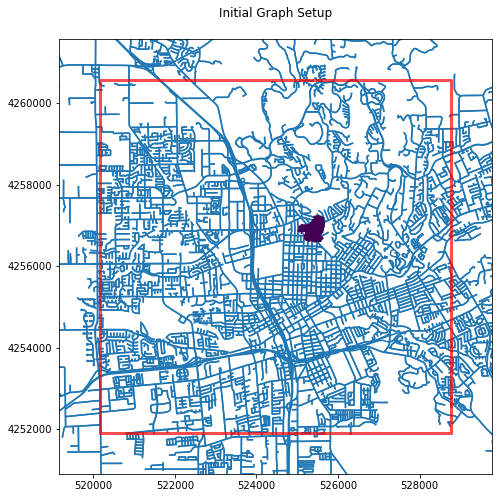

In [7]:
# Save initial setup graph

fig, ax = check_graphs(gdf_edges, x=x, y=y, shpfile=init_fire)
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
title = ax.text(0.5, 1.05,"Initial Graph Setup", 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes)
plt.savefig(os.path.join(out_folder, 'initial graph configuration.png'))

In [12]:
# show road graph info
road_graph.graph['crs']

<Projected CRS: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Attribute: rt_weight, Type: int64


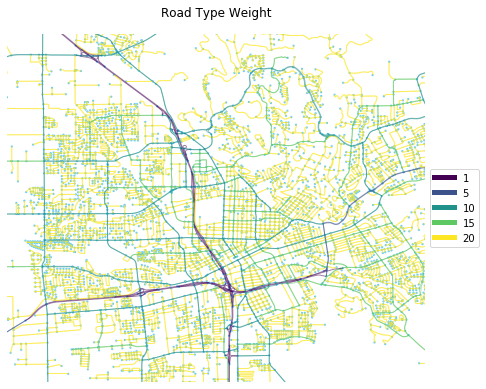

In [9]:
# view major roads (road weights)

fig, ax = view_edge_attrib(road_graph, 'rt_weight', show_val=True, val=[1, 5, 10, 15, 20])
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
title = ax.text(0.5, 1.05,"Road Type Weight", 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes)
plt.savefig(os.path.join(out_folder, 'initial graph roads weights.png'));

Attribute: speed, Type: float64
min 2.24 max 29.06


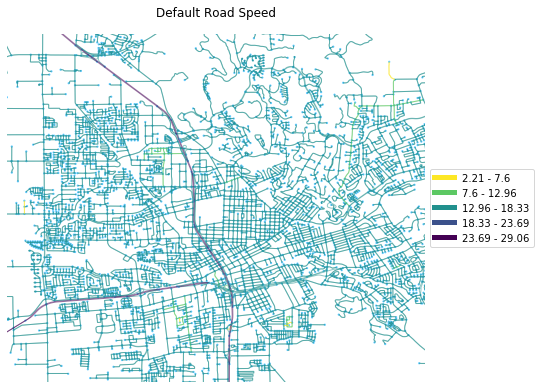

In [18]:
# view speed

fig, ax = view_edge_attrib(road_graph, 'speed', num_bins=5,  cmap='viridis_r')
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
title = ax.text(0.5, 1.05,"Default Road Speed", 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes)
plt.savefig(os.path.join(out_folder, 'initial graph speeds.png'));

In [ ]:
# Define data fieldnames

fieldnames = ['Exp_no', 'NB_no',
                  'Treat_no', 'Rep_no', 'Seed',
                  'Elpsd_time_TS',
                  'Total_cars', 'Stuck_cars',
                  'Num_rds_in_bbox',
                  'veh_by_strat',
                  'Finish_time',
                  'Treat_desc', 'Exp_desc', 'RG_file',
                  'Veh_stat_by_time',
                  'Cong_by_time',
                  'Veh_by_edge',
                  'Init_Veh_coords']

### Check for sucessful and bad seeds

In [ ]:
# Read input data, isolate bad seeds
# Bad seeds are seeds that did not successfully run for all three driving strategies

seed_dict = {}
bad_seeds_fp = set()

with open(in_fn, 'r') as input_csvfile:
    reader = csv.DictReader(input_csvfile, delimiter='\t')
    for row in reader:
        strat = row['veh_by_strat'].split("'")[1]
        seed = int(row['Seed'])
        if seed_dict.get(strat):
            seed_dict[strat].append(seed)
        else:
            seed_dict[strat] = [seed]

all_strats = list(seed_dict.keys())

for dstrat in all_strats:
    print(dstrat+':', len(set(seed_dict[dstrat])), 'seeds')

common_seeds = None
for di in range(len(all_strats)-1):
    if common_seeds == None:
        common_seeds = set(seed_dict[all_strats[di]]) & set(seed_dict[all_strats[di+1]])
    else:
        common_seeds = common_seeds & set(seed_dict[all_strats[di+1]])
        
for dstrat in all_strats:
    print(set(seed_dict[dstrat]) - common_seeds)
    bad_seeds_fp.update((set(seed_dict[dstrat]) - common_seeds))
    
for dstrat in all_strats:
    print(dstrat, len(seed_dict[dstrat]))
    print(sorted(list(seed_dict[dstrat])))
    

print('common seed len:', len(common_seeds))
#print('common seeds:')
#print(common_seeds) 
print('bad seed len:', len(bad_seeds_fp))
print('bad seeds:')
print(sorted(list(bad_seeds_fp))) 
print('cutoff for 100 seeds:', sorted(common_seeds)[99])

cutoff_seed = int(sorted(common_seeds)[99])

<a id='data_coll_format'></a>
## Initial data collection and formatting
([back to Table of Contents](#top))

### Calculate clearance times, initial congestion

In [ ]:
# Calculate clearance times, congestion

# seed dictionaries
bad_seeds = list(bad_seeds_fp)
dist_seeds = []
majr_seeds = []
quik_seeds = []

# total clearance time
tot_clear_times = {'dist':[], 'majr':[], 'quik':[]}
tot_clear_times_seed = {'dist':{}, 'majr':{}, 'quik':{}}

# clearance by time dictionaries (for clearance by time graph)
time_clear_lst_dist = [[], []]
time_clear_lst_majr = [[], []]
time_clear_lst_quik = [[], []]
time_clear_aver_dist = {}
time_clear_aver_majr = {}
time_clear_aver_quik = {}
time_clear_lst_m_std_dist = [[], [], []]
time_clear_lst_m_std_majr = [[], [], []]
time_clear_lst_m_std_quik = [[], [], []]

# congestion by time dictionaries (for congestion by time graph)
time_cong_lst_dist = [[], []]
time_cong_lst_majr = [[], []]
time_cong_lst_quik = [[], []]
time_cong_aver_dist = {}
time_cong_aver_majr = {}
time_cong_aver_quik = {}
time_cong_lst_m_std_dist = [[], [], []]
time_cong_lst_m_std_majr = [[], [], []]
time_cong_lst_m_std_quik = [[], [], []]

# congestion by edge dictionary (for congestion by time maps)
edge_cong_dict_dist = {}
edge_cong_dict_majr = {}
edge_cong_dict_quik = {}

row_count = 0
valid_row_count = 0
with open(in_fn, 'r') as in_csvfile:
    reader = csv.DictReader(in_csvfile, delimiter='\t')
    for row in reader:
        row_count = row_count + 1
        #if row_count >10:
        #    break
        if int(row['Seed']) in bad_seeds:
            #print(row_count, 'sd:', row['Seed'], '=bad seed')
            continue
        if int(row['Seed']) > cutoff_seed: # ran more than needed as some failed, cut off after 100 valid seeds
            continue

        #print(row_count, 'sd:', row['Seed'], '=not bad seed')
        
        strat = row['veh_by_strat'].split("'")[1]
        time_clear = json.loads(row['Veh_stat_by_time'].replace("'", '"'))
        time_cong = json.loads(row['Cong_by_time'].replace("'", '"'))
       
        edge_cong = json.loads(row['Veh_by_edge'].replace("'", '"'))
        
        
        if strat == 'dist':
            if int(row['Seed']) in dist_seeds:
                #print('dist', row_count, 'sd:', row['Seed'], 'seed already counted')
                pass
            else:
                #print('dist sd:', row['Seed'], type(row['Seed']))
                dist_seeds.append(int(row['Seed']))
                valid_row_count = valid_row_count + 1
                
                tot_clear_times['dist'].append(int(row['Elpsd_time_TS']))
                tot_clear_times_seed['dist'][row['Seed']] = int(row['Elpsd_time_TS'])
                # clearance by time dictionaries
                for tcv in time_clear:
                    time_clear_lst_dist[0].append(tcv['ts'])
                    time_clear_lst_dist[1].append(tcv['pctclear'])
                    if tcv['ts'] in time_clear_aver_dist.keys():
                        time_clear_aver_dist[tcv['ts']].append(tcv['pctclear'])
                    else:
                        time_clear_aver_dist[tcv['ts']] = [tcv['pctclear']]

                # congestion by time dictionaries 
                for tcgv in time_cong:
                    time_cong_lst_dist[0].append(tcgv['ts'])
                    time_cong_lst_dist[1].append(tcgv['ave_veh_p_rd'])

                    if tcgv['ts'] in time_cong_aver_dist.keys():
                        time_cong_aver_dist[tcgv['ts']].append(tcgv['ave_veh_p_rd'])
                    else:
                        time_cong_aver_dist[tcgv['ts']] = [tcgv['ave_veh_p_rd']]

            # congestion by edge edge_cong_dict_dist numv
                for edge_key in edge_cong.keys():
                    ec_ts = edge_cong[edge_key][0]['ts']
                    ec_numv = edge_cong[edge_key][0]['numv']
                    if ec_ts in edge_cong_dict_dist.keys():
                        if edge_key in edge_cong_dict_dist[ec_ts].keys():
                            edge_cong_dict_dist[ec_ts][edge_key]['numv_list'].append(ec_numv)
                        else:
                            edge_cong_dict_dist[ec_ts][edge_key] = {}
                            edge_cong_dict_dist[ec_ts][edge_key]['numv_list'] = [ec_numv]
                    else:
                        edge_cong_dict_dist[ec_ts] = {}
                        edge_cong_dict_dist[ec_ts][edge_key] = {}
                        edge_cong_dict_dist[ec_ts][edge_key]['numv_list'] = [ec_numv]
                
        elif strat == 'dist+road_type_weight':
            if int(row['Seed']) in majr_seeds:
                #print('majr', row_count, 'sd:', row['Seed'], 'seed already counted')
                pass
            else:
                #print('major sd:', row['Seed'], type(row['Seed']))
                majr_seeds.append(int(row['Seed']))
                valid_row_count = valid_row_count + 1
                
                tot_clear_times['majr'].append(int(row['Elpsd_time_TS']))
                tot_clear_times_seed['majr'][row['Seed']] = int(row['Elpsd_time_TS'])
                # clearance by time dictionaries
                for tcv in time_clear:
                    time_clear_lst_majr[0].append(tcv['ts'])
                    time_clear_lst_majr[1].append(tcv['pctclear'])
                    if tcv['ts'] in time_clear_aver_majr.keys():
                        time_clear_aver_majr[tcv['ts']].append(tcv['pctclear'])
                    else:
                        time_clear_aver_majr[tcv['ts']] = [tcv['pctclear']]

                # congestion by time dictionaries        
                for tcgv in time_cong:
                    time_cong_lst_majr[0].append(tcgv['ts'])
                    time_cong_lst_majr[1].append(tcgv['ave_veh_p_rd'])

                    if tcgv['ts'] in time_cong_aver_majr.keys():
                        time_cong_aver_majr[tcgv['ts']].append(tcgv['ave_veh_p_rd'])
                    else:
                        time_cong_aver_majr[tcgv['ts']] = [tcgv['ave_veh_p_rd']]
                    
            # congestion by edge  edge_cong_dict_majr
                for edge_key in edge_cong.keys():
                    ec_ts = edge_cong[edge_key][0]['ts']
                    ec_numv = edge_cong[edge_key][0]['numv']
                    if ec_ts in edge_cong_dict_majr.keys():
                        if edge_key in edge_cong_dict_majr[ec_ts].keys():
                            edge_cong_dict_majr[ec_ts][edge_key]['numv_list'].append(ec_numv)
                        else:
                            edge_cong_dict_majr[ec_ts][edge_key] = {}
                            edge_cong_dict_majr[ec_ts][edge_key]['numv_list'] = [ec_numv]
                    else:
                        edge_cong_dict_majr[ec_ts] = {}
                        edge_cong_dict_majr[ec_ts][edge_key] = {}
                        edge_cong_dict_majr[ec_ts][edge_key]['numv_list'] = [ec_numv]
        
        elif strat == 'quickest':
            if int(row['Seed']) in quik_seeds:
                #print('majr', row_count, 'sd:', row['Seed'], 'seed already counted')
                pass
            else:
                #print('quick sd:', row['Seed'], type(row['Seed']))
                quik_seeds.append(int(row['Seed']))
                valid_row_count = valid_row_count + 1
                
                tot_clear_times['quik'].append(int(row['Elpsd_time_TS']))
                tot_clear_times_seed['quik'][row['Seed']] = int(row['Elpsd_time_TS'])
                # clearance by time dictionaries
                for tcv in time_clear:
                    time_clear_lst_quik[0].append(tcv['ts'])
                    time_clear_lst_quik[1].append(tcv['pctclear'])
                    if tcv['ts'] in time_clear_aver_quik.keys():
                        time_clear_aver_quik[tcv['ts']].append(tcv['pctclear'])
                    else:
                        time_clear_aver_quik[tcv['ts']] = [tcv['pctclear']]

                # congestion by time dictionaries        
                for tcgv in time_cong:
                    time_cong_lst_quik[0].append(tcgv['ts'])
                    time_cong_lst_quik[1].append(tcgv['ave_veh_p_rd'])

                    if tcgv['ts'] in time_cong_aver_quik.keys():
                        time_cong_aver_quik[tcgv['ts']].append(tcgv['ave_veh_p_rd'])
                    else:
                        time_cong_aver_quik[tcgv['ts']] = [tcgv['ave_veh_p_rd']]
                    
            # congestion by edge  edge_cong_dict_majr
                for edge_key in edge_cong.keys():
                    ec_ts = edge_cong[edge_key][0]['ts']
                    ec_numv = edge_cong[edge_key][0]['numv']
                    if ec_ts in edge_cong_dict_quik.keys():
                        if edge_key in edge_cong_dict_quik[ec_ts].keys():
                            edge_cong_dict_quik[ec_ts][edge_key]['numv_list'].append(ec_numv)
                        else:
                            edge_cong_dict_quik[ec_ts][edge_key] = {}
                            edge_cong_dict_quik[ec_ts][edge_key]['numv_list'] = [ec_numv]
                    else:
                        edge_cong_dict_quik[ec_ts] = {}
                        edge_cong_dict_quik[ec_ts][edge_key] = {}
                        edge_cong_dict_quik[ec_ts][edge_key]['numv_list'] = [ec_numv]
                
# clearance by time dictionaries (for clearance graph)
for key in time_clear_aver_dist.keys():
    time_clear_lst_m_std_dist[0].append(key)
    time_clear_lst_m_std_dist[1].append(sum(time_clear_aver_dist[key])/len(time_clear_aver_dist[key]))
    if len(time_clear_aver_dist[key])>1:
        time_clear_lst_m_std_dist[2].append(statistics.stdev(time_clear_aver_dist[key]))
    else:
        time_clear_lst_m_std_dist[2].append(0)
    
for key in time_clear_aver_majr.keys():
    time_clear_lst_m_std_majr[0].append(key)
    time_clear_lst_m_std_majr[1].append(sum(time_clear_aver_majr[key])/len(time_clear_aver_majr[key]))
    if len(time_clear_aver_majr[key]) > 1:
        time_clear_lst_m_std_majr[2].append(statistics.stdev(time_clear_aver_majr[key]))
    else:
        time_clear_lst_m_std_majr[2].append(0)
        
for key in time_clear_aver_quik.keys():
    time_clear_lst_m_std_quik[0].append(key)
    time_clear_lst_m_std_quik[1].append(sum(time_clear_aver_quik[key])/len(time_clear_aver_quik[key]))
    if len(time_clear_aver_quik[key]) > 1:
        time_clear_lst_m_std_quik[2].append(statistics.stdev(time_clear_aver_quik[key]))
    else:
        time_clear_lst_m_std_quik[2].append(0)
    
# congestion by time dictionaries (for congestion by time graph)
for key in time_cong_aver_dist.keys():
    time_cong_lst_m_std_dist[0].append(key)
    time_cong_lst_m_std_dist[1].append(sum(time_cong_aver_dist[key])/len(time_cong_aver_dist[key]))
    if len(time_cong_aver_dist[key]) > 1:
        time_cong_lst_m_std_dist[2].append(statistics.stdev(time_cong_aver_dist[key]))
    else:
        time_cong_lst_m_std_dist[2].append(0)
    
for key in time_cong_aver_majr.keys():
    time_cong_lst_m_std_majr[0].append(key)
    time_cong_lst_m_std_majr[1].append(sum(time_cong_aver_majr[key])/len(time_cong_aver_majr[key]))
    if len(time_cong_aver_majr[key]) > 1:
        time_cong_lst_m_std_majr[2].append(statistics.stdev(time_cong_aver_majr[key]))
    else:
        time_cong_lst_m_std_majr[2].append(0)
        
for key in time_cong_aver_quik.keys():
    time_cong_lst_m_std_quik[0].append(key)
    time_cong_lst_m_std_quik[1].append(sum(time_cong_aver_quik[key])/len(time_cong_aver_quik[key]))
    if len(time_cong_aver_quik[key]) > 1:
        time_cong_lst_m_std_quik[2].append(statistics.stdev(time_cong_aver_quik[key]))
    else:
        time_cong_lst_m_std_quik[2].append(0)


# Congestion by edge by time dictionaries
for time_key in edge_cong_dict_dist.keys():
    for edge_key in edge_cong_dict_dist[time_key]:
        edge_cong_dict_dist[time_key][edge_key]['ave_veh'] = round(sum(edge_cong_dict_dist[time_key][edge_key]['numv_list'])/len(edge_cong_dict_dist[time_key][edge_key]['numv_list']), 2)

for time_key in edge_cong_dict_majr.keys():
    for edge_key in edge_cong_dict_majr[time_key]:
        edge_cong_dict_majr[time_key][edge_key]['ave_veh'] = round(sum(edge_cong_dict_majr[time_key][edge_key]['numv_list'])/len(edge_cong_dict_majr[time_key][edge_key]['numv_list']), 2)

for time_key in edge_cong_dict_quik.keys():
    for edge_key in edge_cong_dict_quik[time_key]:
        edge_cong_dict_quik[time_key][edge_key]['ave_veh'] = round(sum(edge_cong_dict_quik[time_key][edge_key]['numv_list'])/len(edge_cong_dict_quik[time_key][edge_key]['numv_list']), 2)

print('total rows seen:', row_count)
print('valid rows seen:', valid_row_count)
print('numb dist', len(dist_seeds))
print('numb majr', len(majr_seeds))
print('numb quik', len(quik_seeds))

### Format congestion for time chart

In [ ]:
# Create congestion map time chart setup

new_run = True
if new_run:
    for time_key in edge_cong_dict_dist.keys():
        d_edge_cong_timekey_dict = {}
        col_name = 'd_t'+str(time_key)+'_ave_veh'
        col_name_ln = 'd_t'+str(time_key)+'_aveh_plngth'
        for edge_key in edge_cong_dict_dist[time_key]:
            d_edge_cong_timekey_dict[eval(edge_key)] = edge_cong_dict_dist[time_key][edge_key]['ave_veh']
        nx.set_edge_attributes(road_graph, d_edge_cong_timekey_dict, col_name)
        #print(set(d_edge_cong_timekey_dict.values())
        for e in road_graph.edges(keys=True, data=True):
            if col_name not in e[3]:
                e[3][col_name] = 0.0
            e[3][col_name_ln] = e[3][col_name]/e[3]['length']
                
    for time_key in edge_cong_dict_majr.keys():
        m_edge_cong_timekey_dict = {}
        col_name = 'm_t'+str(time_key)+'_ave_veh'
        col_name_ln = 'm_t'+str(time_key)+'_aveh_plngth'
        for edge_key in edge_cong_dict_majr[time_key]:
            m_edge_cong_timekey_dict[eval(edge_key)] = edge_cong_dict_majr[time_key][edge_key]['ave_veh']
        nx.set_edge_attributes(road_graph, m_edge_cong_timekey_dict, col_name)
        #print(set(m_edge_cong_timekey_dict.values()))
        for e in road_graph.edges(keys=True, data=True):
            if col_name not in e[3]:
                e[3][col_name] = 0.0
            e[3][col_name_ln] = e[3][col_name]/e[3]['length']
            
    for time_key in edge_cong_dict_quik.keys():
        m_edge_cong_timekey_dict = {}
        col_name = 'q_t'+str(time_key)+'_ave_veh'
        col_name_ln = 'q_t'+str(time_key)+'_aveh_plngth'
        for edge_key in edge_cong_dict_quik[time_key]:
            m_edge_cong_timekey_dict[eval(edge_key)] = edge_cong_dict_quik[time_key][edge_key]['ave_veh']
        nx.set_edge_attributes(road_graph, m_edge_cong_timekey_dict, col_name)
        #print(set(m_edge_cong_timekey_dict.values()))
        for e in road_graph.edges(keys=True, data=True):
            if col_name not in e[3]:
                e[3][col_name] = 0.0
            e[3][col_name_ln] = e[3][col_name]/e[3]['length']

In [ ]:
# export new edge data

gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)

<a id='create_kernel_maps'></a>
## Create kernel density maps
([back to Table of Contents](#top))

In [ ]:
# Make KDE Map folders

if not os.path.isdir(os.path.join(out_folder, 'dist_k_dens')):
    os.mkdir(os.path.join(out_folder, 'dist_k_dens'))
if not os.path.isdir(os.path.join(out_folder, 'majr_k_dens')):
    os.mkdir(os.path.join(out_folder, 'majr_k_dens'))
if not os.path.isdir(os.path.join(out_folder, 'quik_k_dens')):
    os.mkdir(os.path.join(out_folder, 'quik_k_dens'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_movies')):
    os.mkdir(os.path.join(out_folder, 'k_dens_movies'))

### Create kernel density maps per driving strategy
#### (normalized by driving strategy min and max)

In [ ]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

dist_art_frame = []
dist_times = sorted([time_key for time_key in edge_cong_dict_dist.keys()])
dist_k_dens = {}
dist_k_range = {'min':[], 'max':[]}

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]
    
for dist_time_key in dist_times:
    col_name = 'd_t'+str(dist_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    dist_k_dens[dist_time_key] = zi
    dist_k_range['min'].append(zi.min())
    dist_k_range['max'].append(zi.max())
    
for dist_time_key in dist_times:
    zi = dist_k_dens[dist_time_key]
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=min(dist_k_range['min']), 
                          vmax=sum(dist_k_range['max'])/len(dist_k_range['max']), 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Shortest Distance: Time {}".format(dist_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    dist_art_frame.append([kdens, title])
        
dist_ani = animation.ArtistAnimation(fig, dist_art_frame, interval=2000, blit=False)

plt.close()

In [ ]:
dist_ani.save(os.path.join(out_folder, 'k_dens_movies', 'dist_k_dens_html.mp4'))

In [ ]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

quik_art_frame = []
quik_times = sorted([time_key for time_key in edge_cong_dict_quik.keys()])
quik_k_dens = {}
quik_k_range = {'min':[], 'max':[]}

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]


for quik_time_key in quik_times:
    col_name = 'q_t'+str(quik_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    quik_k_dens[quik_time_key] = zi
    quik_k_range['min'].append(zi.min())
    quik_k_range['max'].append(zi.max())
    
for quik_time_key in quik_times:  
    zi = quik_k_dens[quik_time_key]
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=min(quik_k_range['min']), 
                          vmax=sum(quik_k_range['max'])/len(quik_k_range['max']), 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Quickest: Time {}".format(quik_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    quik_art_frame.append([kdens, title])
    
quik_ani = animation.ArtistAnimation(fig, quik_art_frame, interval=2000, blit=False)

plt.close()

In [ ]:
quik_ani.save(os.path.join(out_folder, 'k_dens_movies', 'quik_k_dens_html.mp4'))

In [ ]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

majr_art_frame = []
majr_times = sorted([time_key for time_key in edge_cong_dict_majr.keys()])
majr_k_dens = {}
majr_k_range = {'min':[], 'max':[]}

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]

    
for majr_time_key in majr_times:
    col_name = 'm_t'+str(majr_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    majr_k_dens[majr_time_key] = zi
    majr_k_range['min'].append(zi.min())
    majr_k_range['max'].append(zi.max())
    
for majr_time_key in majr_times:  
    zi = majr_k_dens[majr_time_key]
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=min(majr_k_range['min']), 
                          vmax=sum(majr_k_range['max'])/len(majr_k_range['max']), 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Major Roads: Time {}".format(majr_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    majr_art_frame.append([kdens, title])

majrd_ani = animation.ArtistAnimation(fig, majr_art_frame, interval=2000, blit=False) 

plt.close()

In [ ]:
majrd_ani.save(os.path.join(out_folder, 'k_dens_movies', 'mjrd_k_dens_html.mp4'))

### Create normalized kernel density maps 
#### (normalized by total min and max)

In [ ]:
# Make KDE Map folders (normalized)

if not os.path.isdir(os.path.join(out_folder, 'dist_k_dens_norm')):
    os.mkdir(os.path.join(out_folder, 'dist_k_dens_norm'))
if not os.path.isdir(os.path.join(out_folder, 'majr_k_dens_norm')):
    os.mkdir(os.path.join(out_folder, 'majr_k_dens_norm'))
if not os.path.isdir(os.path.join(out_folder, 'quik_k_dens_norm')):
    os.mkdir(os.path.join(out_folder, 'quik_k_dens_norm'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_movies_norm')):
    os.mkdir(os.path.join(out_folder, 'k_dens_movies_norm'))

In [ ]:
group_min = min(min(dist_k_range['min']), min(quik_k_range['min']), min(majr_k_range['min']))

maxes = list(dist_k_range['max'])
maxes.extend(quik_k_range['max'])
maxes.extend(majr_k_range['max'])

group_max = sum(maxes)/len(maxes)
group_max = statistics.median(maxes)

In [ ]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

dist_art_frame_norm = []

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]
        
for dist_time_key in dist_times:
    col_name = 'd_t'+str(dist_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=group_min, 
                          vmax=group_max, 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Shortest Distance: Time {}".format(dist_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    dist_art_frame_norm.append([kdens, title])
        
dist_ani_norm = animation.ArtistAnimation(fig, dist_art_frame_norm, interval=2000, blit=False)

plt.close()

In [ ]:
dist_ani_norm.save(os.path.join(out_folder, 'k_dens_movies_norm', 'dist_k_dens_norm_html.mp4'))

In [ ]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

quik_art_frame_norm = []

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]

    
for quik_time_key in quik_times:  
    col_name = 'q_t'+str(quik_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=group_min, 
                          vmax=group_max, 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Quickest: Time {}".format(quik_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    quik_art_frame_norm.append([kdens, title])
    
quik_ani_norm = animation.ArtistAnimation(fig, quik_art_frame_norm, interval=2000, blit=False)

plt.close()

In [ ]:
quik_ani_norm.save(os.path.join(out_folder, 'k_dens_movies_norm', 'quik_k_dens_norm_html.mp4'))

In [ ]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

majr_art_frame_norm = []

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]
    
for majr_time_key in majr_times:  
    col_name = 'm_t'+str(majr_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=group_min, 
                          vmax=group_max, 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Major Roads: Time {}".format(majr_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    majr_art_frame_norm.append([kdens, title])

majrd_ani_norm = animation.ArtistAnimation(fig, majr_art_frame_norm, interval=2000, blit=False) 

plt.close()

In [ ]:
majrd_ani_norm.save(os.path.join(out_folder, 'k_dens_movies_norm', 'mjrd_k_dens_norm_html.mp4'))

### Export stills from animations

In [ ]:
# Make KDE Map folders

if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills', 'mjrd')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills', 'mjrd'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills', 'quik')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills', 'quik'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills', 'dist')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills', 'dist'))

In [ ]:
# Make KDE Map folders

if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm', 'mjrd')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm', 'mjrd'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm', 'quik')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm', 'quik'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm', 'dist')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm', 'dist'))

In [ ]:
# Save frames

for strat in ['quik', 'dist', 'mjrd']:
    vid = os.path.join(out_folder, 'k_dens_movies', strat+'_k_dens_html.mp4')
    video_cap = cv2.VideoCapture(vid)
    success, image = video_cap.read()
    count = 0
    while success:
        ofn = os.path.join(out_folder, 'k_dens_stills', strat, strat+"_ts_"+str(count)+".jpg")
        cv2.imwrite(ofn, image) # save frame as JPEG file      
        success, image = video_cap.read()
        count += 25

In [ ]:
# Save frames

for strat in ['quik', 'dist', 'mjrd']:
    vid = os.path.join(out_folder, 'k_dens_movies_norm', strat+'_k_dens_norm_html.mp4')
    video_cap = cv2.VideoCapture(vid)
    success, image = video_cap.read()
    count = 0
    while success:
        ofn = os.path.join(out_folder, 'k_dens_stills_norm', strat, strat+"_norm_ts_"+str(count)+".jpg")
        cv2.imwrite(ofn, image) # save frame as JPEG file      
        success, image = video_cap.read()
        count += 25

<a id='assess_clearance'></a>
## Assess clearance times
([back to Table of Contents](#top))

### Assert same number, same keys, sort by seed

In [ ]:
# Clearance Time mean comparison set up

assert sorted(tot_clear_times_seed['dist'].keys()) == sorted(tot_clear_times_seed['majr'].keys()) == sorted(tot_clear_times_seed['quik'].keys())
sorted_key_list = sorted([int(x) for x in tot_clear_times_seed['dist'].keys()])

dist_t_ct = [tot_clear_times_seed['dist'][str(x)] for x in sorted_key_list]
majr_t_ct = [tot_clear_times_seed['majr'][str(x)] for x in sorted_key_list]
quik_t_ct = [tot_clear_times_seed['quik'][str(x)] for x in sorted_key_list]

### Check for normality

In [ ]:
# plot distributions and qq plots

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2,  figsize=(6,6))
ax1.hist(quik_t_ct, color='orange')
ax1.set_title('Quickest')
ax1.set_ylim(0, 35)
ax1.set_xlim(250, 600)

stats.probplot(numpy.asarray(quik_t_ct), plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('orange')
ax2.get_lines()[0].set_markeredgewidth(0)
ax2.get_lines()[1].set_color('black')

ax3.hist(dist_t_ct, color='blue')
ax3.set_title('Shortest Distance')
ax3.set_ylim(0, 35)
ax3.set_xlim(250, 600)

stats.probplot(numpy.asarray(dist_t_ct), plot=ax4)
ax4.get_lines()[0].set_markerfacecolor('blue')
ax4.get_lines()[0].set_markeredgewidth(0)
ax4.get_lines()[1].set_color('black')

ax5.hist(majr_t_ct, color='red')
ax5.set_title('Major Roads')
ax5.set_ylim(0, 35)
ax5.set_xlim(250, 600)

stats.probplot(numpy.asarray(majr_t_ct), plot=ax6)
ax6.get_lines()[0].set_markerfacecolor('red')
ax6.get_lines()[0].set_markeredgewidth(0)
ax6.get_lines()[1].set_color('black')

fig.tight_layout()

plt.savefig(os.path.join(out_folder, 'histograms and qq plots.png'))

In [ ]:
# set alpha value

alpha = 0.05

In [ ]:
# Calculate Shapiro-Wilk test for normality

stat, p = stats.shapiro(quik_t_ct)
print('Quickest: Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
# Calculate Shapiro-Wilk test for normality

stat, p = stats.shapiro(dist_t_ct)
print('Shortest Distance: Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
# Calculate Shapiro-Wilk test for normality

stat, p = stats.shapiro(majr_t_ct)
print('Major Roads: Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
# Calculate Friedman Test to assess if repeated measues have the same distributions

stat, p = stats.friedmanchisquare(majr_t_ct, quik_t_ct, dist_t_ct)
print('Friedman Statistics=%.3f, p=%.3f' % (stat, p)) #df = k (num groups -1) = 3-1 = 2 (df = 2, n = 100)


<a id='graph_clearance'></a>
## Graph clearance times
([back to Table of Contents](#top))

In [ ]:
# Create clearance time boxplot

colors= ['orange', 'blue', 'red']

fig, ax = plt.subplots()
s = ax.boxplot((tot_clear_times['quik'], tot_clear_times['dist'], tot_clear_times['majr']))
for idx, median in enumerate(s['medians']):
    median.set(color=colors[idx], linewidth=1.5)
s = ax.set_xticklabels(('Quickest', 'Shortest Distance', 'Major Roads'))
s = ax.set_title('Clearance times per Driving Strategy')
s = ax.set_ylabel('Time (s)')

plt.savefig(os.path.join(out_folder,'clearance times per driving strategy.png'))

In [ ]:
# Graph clearance times per driving strategy per seed

vid = ['_'+str(x) for x in range(0, 100)]
colorl = ['gray' for x in range(0, 100)]

data = {'vid':vid,
        'dist':dist_t_ct,
       'quik':quik_t_ct,
       'majr':majr_t_ct}

df = pd.DataFrame(data, columns=["vid","quik","dist","majr"])

s = df.plot(color=['orange','blue','red'])
s.legend(['Quickest', 'Shortest Distance', 'Major Roads'], bbox_to_anchor=(1, 1));
s.set_ylabel('Time (s)')
s.set_xlabel('Seed order')
plt.title('Clearance times per Driving Strategy by Seed');

plt.savefig(os.path.join(out_folder,'clearance times per driving strategy by seed.png'))

In [ ]:
# Graph precent cleared by time chart

fig, ax = plt.subplots()

s = ax.plot(time_clear_lst_m_std_quik[0], time_clear_lst_m_std_quik[1], c='orange', alpha=0.5,  label='Quickest')
s = ax.errorbar(time_clear_lst_m_std_quik[0], time_clear_lst_m_std_quik[1], 
                time_clear_lst_m_std_quik[2], capsize=5, c='orange', alpha=0.25)

s = ax.plot(time_clear_lst_m_std_dist[0], time_clear_lst_m_std_dist[1], c='blue', alpha=0.5,  label='Shortest Distance')
s = ax.errorbar(time_clear_lst_m_std_dist[0], time_clear_lst_m_std_dist[1], 
                time_clear_lst_m_std_dist[2], capsize=5, c='blue', alpha=0.25)


s = ax.plot(time_clear_lst_m_std_majr[0], time_clear_lst_m_std_majr[1], c='red', alpha=0.5, label='Major Roads')
s = ax.errorbar(time_clear_lst_m_std_majr[0], time_clear_lst_m_std_majr[1], 
                time_clear_lst_m_std_majr[2], capsize=5, c='red', alpha=0.25)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Cleared vehicles (%)')
plt.title('Precentage of Cleared Vehicles by Driving Strategy')
s = ax.legend()

plt.savefig(os.path.join(out_folder,'percent clearance vehicles by time per driving strategy.png'))

<a id='graph_congestion'></a>
## Graph congestion chart
([back to Table of Contents](#top))

In [ ]:
# Congstion by time chart

fig, ax = plt.subplots()

s = ax.plot(time_cong_lst_m_std_quik[0], time_cong_lst_m_std_quik[1], c='orange', alpha=0.5,  label='Quickest')
s = ax.errorbar(time_cong_lst_m_std_quik[0], time_cong_lst_m_std_quik[1], 
                time_cong_lst_m_std_quik[2], capsize=5, c='orange', alpha=0.25)

s = ax.plot(time_cong_lst_m_std_dist[0], time_cong_lst_m_std_dist[1], c='blue', alpha=0.5,  label='Shortest Distance')
s = ax.errorbar(time_cong_lst_m_std_dist[0], time_cong_lst_m_std_dist[1], 
                time_cong_lst_m_std_dist[2], capsize=5, c='blue', alpha=0.25)

s = ax.plot(time_cong_lst_m_std_majr[0], time_cong_lst_m_std_majr[1], c='red', alpha=0.5, label='Major Roads')
s = ax.errorbar(time_cong_lst_m_std_majr[0], time_cong_lst_m_std_majr[1], 
                time_cong_lst_m_std_majr[2], capsize=5, c='red', alpha=0.25)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Congestion (total vehicles per number \nof road segments that containing vehicles)')
plt.title('Average Edge Congestion by Driving Strategy')
s = ax.legend()
plt.savefig(os.path.join(out_folder,'average edge congestion by time per driving strategy.png'))